In [1]:
%matplotlib inline 


import numpy as np #To use functions or constants that are in the NumPy module, type np.function_name. EG: np.pi is pi
import numpy.random as nprd #This imports random number generation functions
import scipy as sp #SciPy has lots of useful numerical methods, so we don't have to write them
import scipy.linalg as spla #This imports the sub-module containing linear algebra methods
import matplotlib.pyplot as plt #This will let us display images nicely
import cv2
#import pandas as pd 
from scipy import ndimage
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering


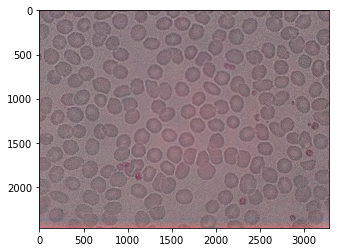

In [60]:
img = cv2.imread('H:\\dos\\Reading Courses\\Malaria Imaging\\me31F_300_a 26 SEPT 2018\\2_8.jpg')
plt.imshow(img)
plt.show()


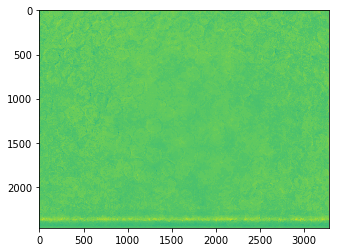

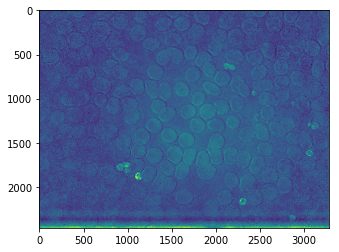

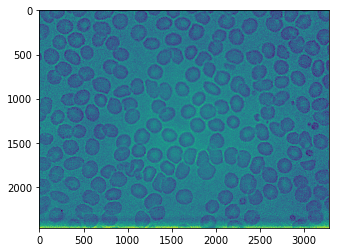

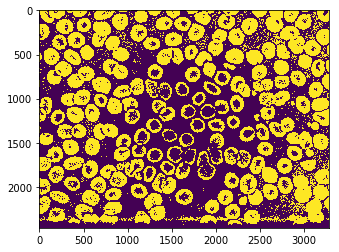

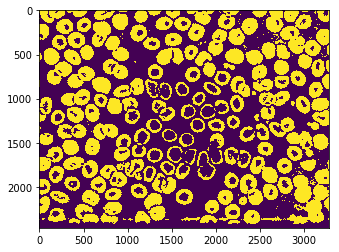

In [61]:
## Convert to HSV colour space 
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_h=img_hsv[:,:,0]
img_s=img_hsv[:,:,1]
img_v=img_hsv[:,:,2]

plt.imshow(img_h)
plt.show()
plt.imshow(img_s)
plt.show()
plt.imshow(img_v)
plt.show()

blur = cv2.GaussianBlur(img_v,(3,3),0)
ret_v,th_v = cv2.threshold(255-blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th_v)
plt.show()

kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
opening_v = cv2.morphologyEx(th_v, cv2.MORPH_OPEN, kernel1)
kernel2= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
closing_v = cv2.morphologyEx(opening_v, cv2.MORPH_CLOSE, kernel2)
plt.imshow(closing_v)
plt.show()


In [62]:

def look_again(img):
    rectangle=[]
    ret_v,th_v = cv2.threshold(255-img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    opening_v = cv2.morphologyEx(th_v, cv2.MORPH_OPEN, kernel1)
    kernel2= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    closing_v = cv2.morphologyEx(opening_v, cv2.MORPH_CLOSE, kernel2)


    contours = cv2.findContours(closing_v, 1, 2)
    for i in range(np.shape(contours[1])[0]):
        cnt = contours[1][i]

        area=cv2.contourArea(cnt)
        print(area)
        x,y,w,h = cv2.boundingRect(cnt)
        if 30000>area>12000:
            print([x,y,w,h])
            rectangle.append([x,y,w,h])
        elif area>30000:
            mask=np.zeros(np.shape(img))
            cv2.fillConvexPoly(mask, cnt, 255)
            mask=mask.astype(bool)
            graph = image.img_to_graph(closing_v, mask=mask)
            graph.data = np.exp(-graph.data / graph.data.std())
            labels = spectral_clustering(graph, n_clusters=np.floor(area/20000), eigen_solver='arpack')
            label_im = np.full(mask.shape, -1.)
            label_im[mask] = labels
            cont=cv2.findContours(label_im, 1, 2)
            for k in range(np.shape(cont[1])[0]):
                cnt = contours[1][k]
                x,y,w,h = cv2.boundingRect(cnt)
                rectangle.append([x,y,w,h])
    rectangle = np.uint16(np.around(rectangle))        
    return(rectangle)

21.0
10.0
14.0
399.0
1470.0
10.0
155.0
2230.5
22914.0
[9, 0, 187, 167]


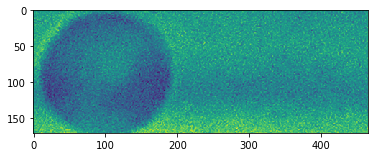

1613.0
190.0
12620.5
[21, 116, 251, 92]
18.0
10.0
10.0
1136.0
9917.5


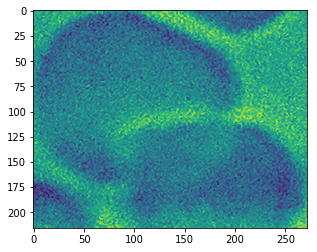

13.0
11.0
10.0
227.0
33256.5


C:\Users\magd21\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

In [63]:
#normalise cut???

pictures = {}
number=0
def PolygonArea(corners):
    n = len(corners)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area


contours = cv2.findContours(closing_v, 1, 2)
for i in range(np.shape(cv2.findContours(closing_v, 1, 2)[1])[0]):
    cnt = contours[1][i]
    area=cv2.contourArea(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    
    if 30000>area>12000:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),10)
        img_new= img_v[int(y):int(y+h)+1,int(x):int(x+w)+1]
      #  cv2.imwrite ('H:\\dos\\Reading Courses\\Malaria Imaging\\cropped_images\\0_1_crop'+str(i)+'.tiff',  img_new)
        pictures[number] = img_new
        number=number+1
#         plt.imshow(img_new)
#         plt.show()
    elif area>30000:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),10)
        #print(x,y)
        img_new= img_v[int(y):int(y+h)+1,int(x):int(x+w)+1]
        mask_new=closing_v[int(y):int(y+h)+1,int(x):int(x+w)+1]
        cv2.imwrite ('H:\\dos\\Reading Courses\\Malaria Imaging\\multi_cell_examples\\0_1_crop'+str(i)+'.tiff',  img_new)
        cv2.imwrite ('H:\\dos\\Reading Courses\\Malaria Imaging\\multi_cell_examples\\0_1_mask'+str(i)+'.tiff',  mask_new)
      #print(img_new)
        rectangles =look_again(img_new)
        #print(circles)
        for j in range(np.shape(rectangles)[0]):
            x1=rectangles[j,0]
            y1=rectangles[j,1]
            h1=rectangles[j,2]
            w1=rectangles[j,3]
            cv2.rectangle(img,(int(x+x1),int(y+y1)),(int(x+x1+w1),int(y+y1+h1)),(255,0,0),10)
            img1=img_v[int(y+y1):int(y+y1+h1)+1,int(x+x1):int(x+x1+w1)+1]
            pictures[number] = img1
            number=number+1
           
        plt.imshow(img_new )
        plt.show()


plt.imshow(img)
plt.show()
#cv2.imwrite('H:\\dos\Reading Courses\\Malaria Imaging\\Example2.tiff',img)

In [ ]:
def hough(img): #Hough circle transform 
   
    try:
     
        img = cv2.medianBlur(img,7)
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=30,param2=15,minRadius=60,maxRadius=90)



        store=np.zeros(np.shape(circles[0,:])[0])+1
        for n in range(np.shape(store)[0]):
            i=circles[0,n]
            for j in range(n):
                if store[j]==1:
                    other=circles[0,j]
                    if (other[0]-i[0])**2+(other[1]-i[1])**2 < 100**2:
                        store[n]=0
        #                 print(other[0],i[0])
        #                 print(other[1],i[1])
        #                 print((other[0]-i[0]),(other[1]-i[1]) )
        #                 print((other[0]-i[0])**2,(other[1]-i[1])**2 )



        store=np.array(store, dtype=np.bool)
        circles2=circles[0,:]
        circles2= circles2[store,:]
        circles2 = np.uint16(np.around(circles2))


        return(circles2)
    except Exception:# NEED TO SORT THIS!!!!!!!!!!!!!!!!
        return()

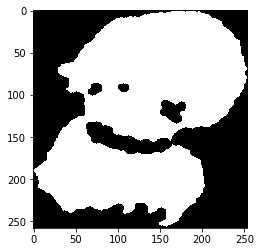

In [ ]:
test_image= cv2.imread('H:\\dos\\Reading Courses\\Malaria Imaging\\multi_cell_examples\\0_1_mask43.tiff')

plt.imshow(test_image)
plt.show()

mask = test_image.astype(bool)

test_img = test_image.astype(float)
test_img += 1 + 0.2 * np.random.randn(*test_img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(test_image, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=2, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

plt.matshow(test_img)
plt.matshow(label_im)



12437.0
17575.0


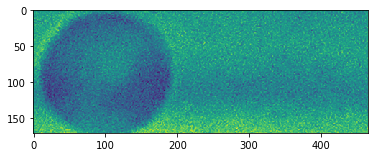

25289.5
24048.0


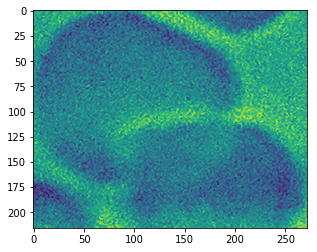

26959.0


C:\Users\magd21\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in ushort_scalars


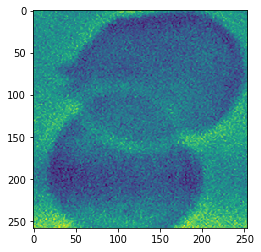

19745.5
18323.0
25018.0
21867.0
23349.5
26090.5
27747.0
21213.5
25080.0
24384.0
15660.5
25956.5
22367.5
24403.5


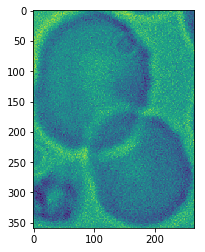

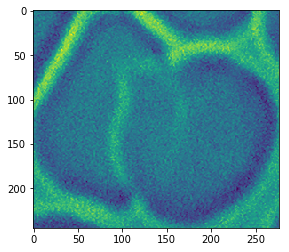

22428.5
20218.0
25359.0


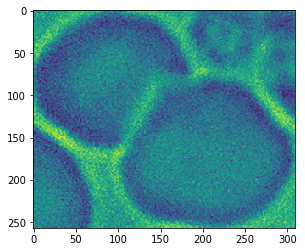

13948.5
19503.0
17274.0


C:\Users\magd21\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in ushort_scalars


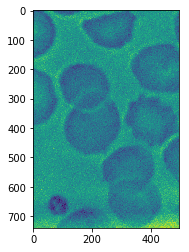

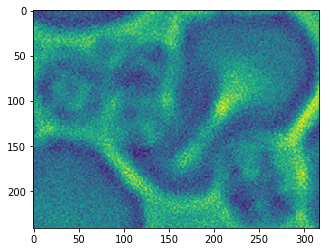

23462.0


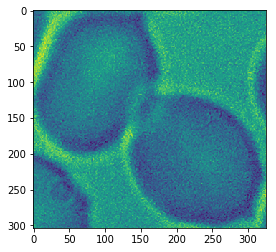

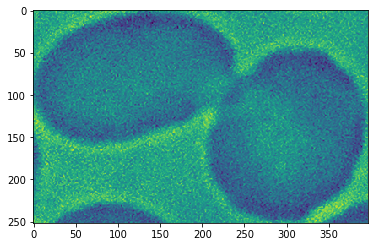

22701.0
14976.0


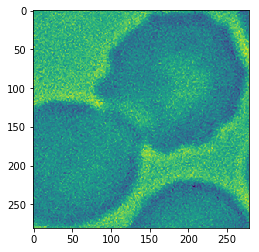

23340.5
21397.5
25322.0
25562.0
12062.5


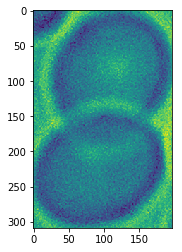

25053.0
14891.5
20537.5
17323.0


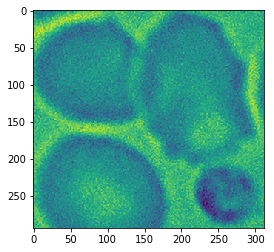

12181.5
19124.0
12298.5
14700.5


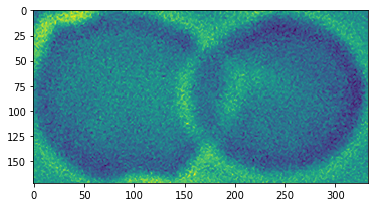

16639.0


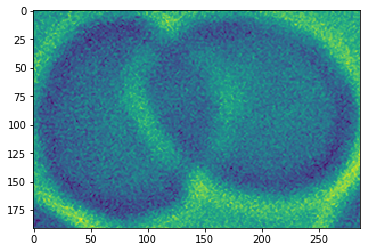

21915.0
21142.5
21191.5


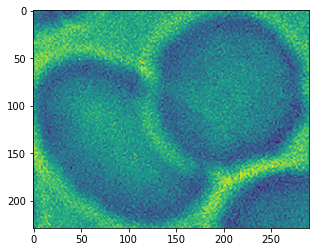

16963.5
24194.5
20731.5
22903.0
27414.5
20817.5
25859.0


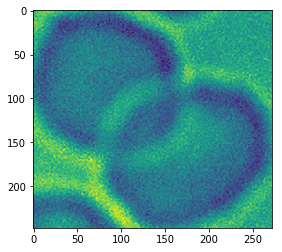

23800.0


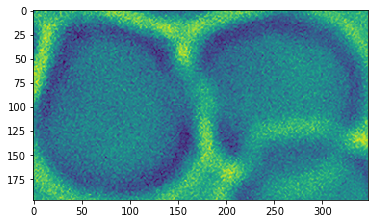

22751.0
25225.0
23873.5
17686.5
17020.5


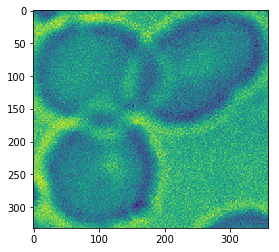

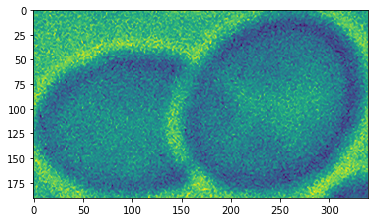

19264.5
22638.5
19995.0


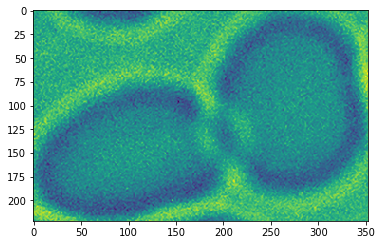

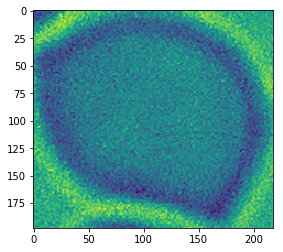

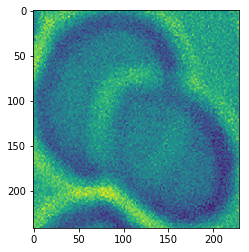

19643.5
23356.0
23438.5
23382.0


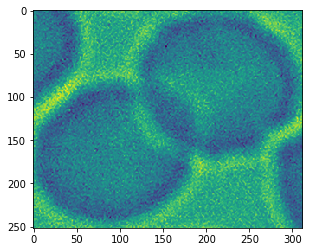

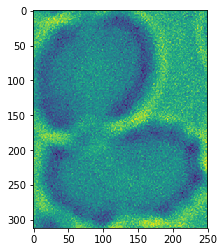

23088.0
18325.0


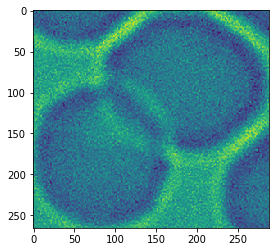

23043.0
24139.0


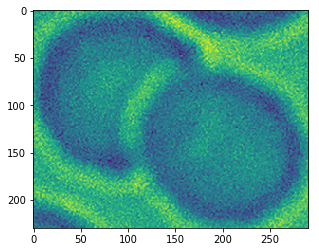

19921.5
19042.0
25428.0
24592.5
28993.0
26194.5


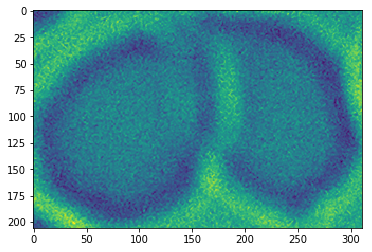

19645.0
19511.0
19181.5
23137.5
21907.0


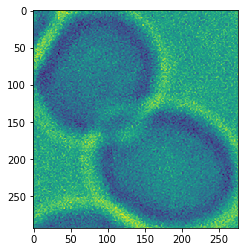

21297.5
23505.5
28272.0


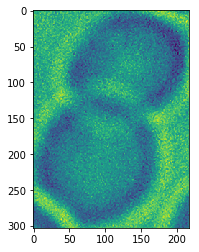

22498.5
27205.0
28000.0
26908.0
16432.5


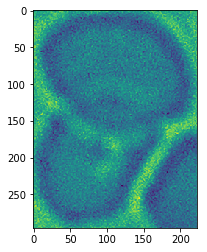

25976.0
27270.5
20973.5
22455.0
23200.5


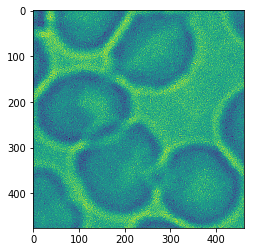

27334.5
12272.0
18359.5


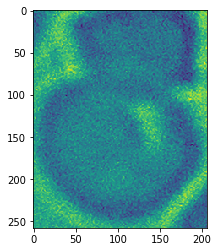

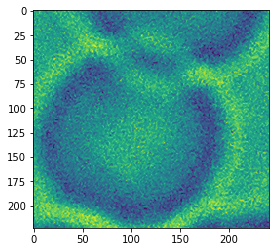

28999.5
16968.0
19148.0
12333.5
27881.0


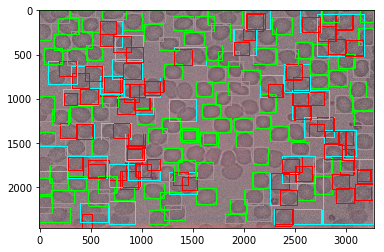

In [49]:
#Using watershed

pictures = {}
number=0
def PolygonArea(corners):
    n = len(corners)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area


contours = cv2.findContours(closing_v, 1, 2)
for i in range(np.shape(contours[1])[0]):
    cnt = contours[1][i]
    area=cv2.contourArea(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    
    if 30000>area>12000:
        print(area)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),10)
        img_new= img_v[int(y):int(y+h)+1,int(x):int(x+w)+1]
      #  cv2.imwrite ('H:\\dos\\Reading Courses\\Malaria Imaging\\cropped_images\\0_1_crop'+str(i)+'.tiff',  img_new)
        pictures[number] = img_new
        number=number+1
#         plt.imshow(img_new)
#         plt.show()
    elif area>30000:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),10)
        #print(x,y)
        img_new= img_v[int(y):int(y+h)+1,int(x):int(x+w)+1]
        cv2.imwrite ('H:\\dos\\Reading Courses\\Malaria Imaging\\c\\0_1_crop'+str(i)+'.tiff',  img_new)
        #print(img_new)
        circles =hough(img_new)
        #print(circles)
        for j in range(np.shape(circles)[0]):
            x1=circles[j,0]-circles[j,2]
            y1=circles[j,1]-circles[j,2]
            h1=circles[j,2]*2
            w1=circles[j,2]*2
            #cv2.rectangle(img_new,np.array([int(x1),int(y1)]),np.array([int(x1+w),int(y1+h)]),255,10)
            cv2.rectangle(img,(int(x+x1),int(y+y1)),(int(x+x1+w1),int(y+y1+h1)),(255,0,0),10)
            img1=img_v[int(y+y1):int(y+y1+h1)+1,int(x+x1):int(x+x1+w1)+1]
            #print('here', img1)
            pictures[number] = img1
            number=number+1
  
        plt.imshow(img_new )
        plt.show()


plt.imshow(img,aspect='auto')
plt.show()
#cv2.imwrite('H:\\dos\Reading Courses\\Malaria Imaging\\Example2.tiff',img)

In [44]:
A=np.array([0,255])

In [45]:
A.astype(bool)

array([False,  True])

In [46]:
A

array([  0, 255])